# PoS Tagger

## Setup de ambiente

In [ ]:
%pip install -r requirements.txt

In [39]:
import pandas as pd
from typing import List, Tuple

## Dados

In [ ]:
train_file = "Penn Treebank/Secs0-18 - training"
dev_file   = "Penn Treebank/Secs19-21 - development"
test_file  = "Penn Treebank/Secs22-24 - testing"

## Preprocessamento

In [52]:
def carregar_corpus(caminho_arquivo: str) -> str:
    with open(caminho_arquivo, "r", encoding="utf-8") as f:
        return f.read()
    
def dividir_em_sentencas(texto: str) -> List[str]:
    return texto.strip().split("\n")

def processar_sentenca(sentenca: str) -> List[Tuple[str, str]]:
    tokens = sentenca.strip().split()
    pares = []
    for token in tokens:
        if "_" in token:
            palavra, tag = token.rsplit("_", 1)
            pares.append((palavra, tag))
    return pares

def construir_dataframe(sentencas: List[str]) -> pd.DataFrame:
    dados = []

    for sent_id, sentenca in enumerate(sentencas):
        palavras_tags = processar_sentenca(sentenca)
        for posicao, (palavra, tag) in enumerate(palavras_tags):
            dados.append({
                "sentenca": sent_id + 1,
                "palavra": palavra,
                "tag": tag,
                "posicao_na_sentenca": posicao
            })

    return pd.DataFrame(dados)

In [60]:
texto_raw = carregar_corpus(train_file)
sentencas = dividir_em_sentencas(texto_raw)
df_treino = construir_dataframe(sentencas)

texto_raw = carregar_corpus(dev_file)
sentencas = dividir_em_sentencas(texto_raw)
df_dev = construir_dataframe(sentencas)

texto_raw = carregar_corpus(test_file)
sentencas = dividir_em_sentencas(texto_raw)
df_teste = construir_dataframe(sentencas)

df_treino

,sentenca,palavra,tag,posicao_na_sentenca
0,1,Pierre,NNP,0
1,1,Vinken,NNP,1
2,1,",",",",2
3,1,61,CD,3
4,1,years,NNS,4
...,...,...,...,...
912339,38219,to,TO,21
912340,38219,San,NNP,22
912341,38219,Francisco,NNP,23
912342,38219,instead,RB,24


## Treino de POS Tagging

In [61]:
from collections import defaultdict, Counter

def treinar_baseline_unigrama(df_treino: pd.DataFrame) -> dict:
    """
    Mapeia cada palavra para sua tag mais frequente no treino.
    """
    tag_frequente = df_treino.groupby("palavra")["tag"].agg(lambda x: Counter(x).most_common(1)[0][0])
    return tag_frequente.to_dict()

def prever_baseline(df_teste: pd.DataFrame, modelo_unigrama: dict, default_tag="NN") -> List[str]:
    """
    Prediz tags com base no mapeamento unigrama. Para palavras desconhecidas, usa default_tag.
    """
    return [modelo_unigrama.get(palavra, default_tag) for palavra in df_teste["palavra"]]

In [62]:
from sklearn.metrics import accuracy_score

def avaliar_acuracia(y_true: List[str], y_pred: List[str]) -> float:
    """
    Calcula acurácia ignorando pontuações e BOS/EOS.
    """
    validas = [(real, pred) for real, pred in zip(y_true, y_pred) if real not in {".", ",", ":", "``", "''", "(", ")", "-NONE-", "BOS", "EOS"}]
    y_true_filtrado, y_pred_filtrado = zip(*validas)
    return accuracy_score(y_true_filtrado, y_pred_filtrado)

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def mostrar_matriz_confusao(y_true: List[str], y_pred: List[str]):
    labels = sorted(list(set(y_true) | set(y_pred)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(30, 30))
    disp.plot(ax=ax, xticks_rotation=90)
    plt.title("Matriz de Confusão - POS Tagger")
    plt.show()

## Avaliação do modelo

Tags previstas: ['NN', 'NNS', 'IN', 'DT', 'NNP', 'NNPS', 'CC', 'NNP', 'NNP', 'VBN', 'NN', 'IN', 'MD', 'VB', 'WRB', 'DT', 'JJ', 'JJ', 'NN', 'NN', 'MD', 'VB', 'NN', ',', 'VBG', 'DT', 'JJ', 'NN', 'TO', 'DT', 'NN', 'POS', 'NN', 'IN', 'JJ', 'NNS', '.', 'DT', 'NN', ',', 'WP$', 'NNS', 'VBP', 'NNP', 'NNP', 'NNP', '-LRB-', 'NNP', ',', 'NNP', '-RRB-', ',', 'MD', 'VB', 'DT', 'NNP', 'NNP', 'NNP', 'IN', 'VBG', 'JJ', 'VBG', 'NN', 'IN', 'VBG', 'DT', 'NN', 'NN', 'CC', 'NN', 'NN', 'NN', 'IN', 'MD', 'RB', 'VB', 'VBN', 'IN', 'DT', 'JJ', 'NN', '.', 'DT', 'NN', 'VBZ', 'TO', 'VB', 'DT', 'NNP', 'TO', 'NNP', 'NNS', 'RB', ',', 'IN', 'DT', 'NN', 'VBZ', 'JJ', 'JJ', 'NN', '.', '``', 'JJ', 'NN', '``', 'NN', 'POS', 'NN', 'VBZ', 'JJ', 'CC', 'JJ', ',', 'RB', 'JJR', 'JJ', 'IN', 'JJ', 'NNP', 'NN', ',', "''", 'VBD', 'NNP', 'NNP', 'NNP', '-LRB-', 'NNP', ',', 'NNP', '-RRB-', ',', 'DT', 'NN', 'POS', 'JJ', 'NN', '.', 'DT', 'JJ', 'NN', 'NN', 'IN', 'DT', 'NN', 'NN', 'NN', 'VBZ', 'VBG', '$', 'CD', 'CD', 'IN', 'NN', 'VBN', 'IN'

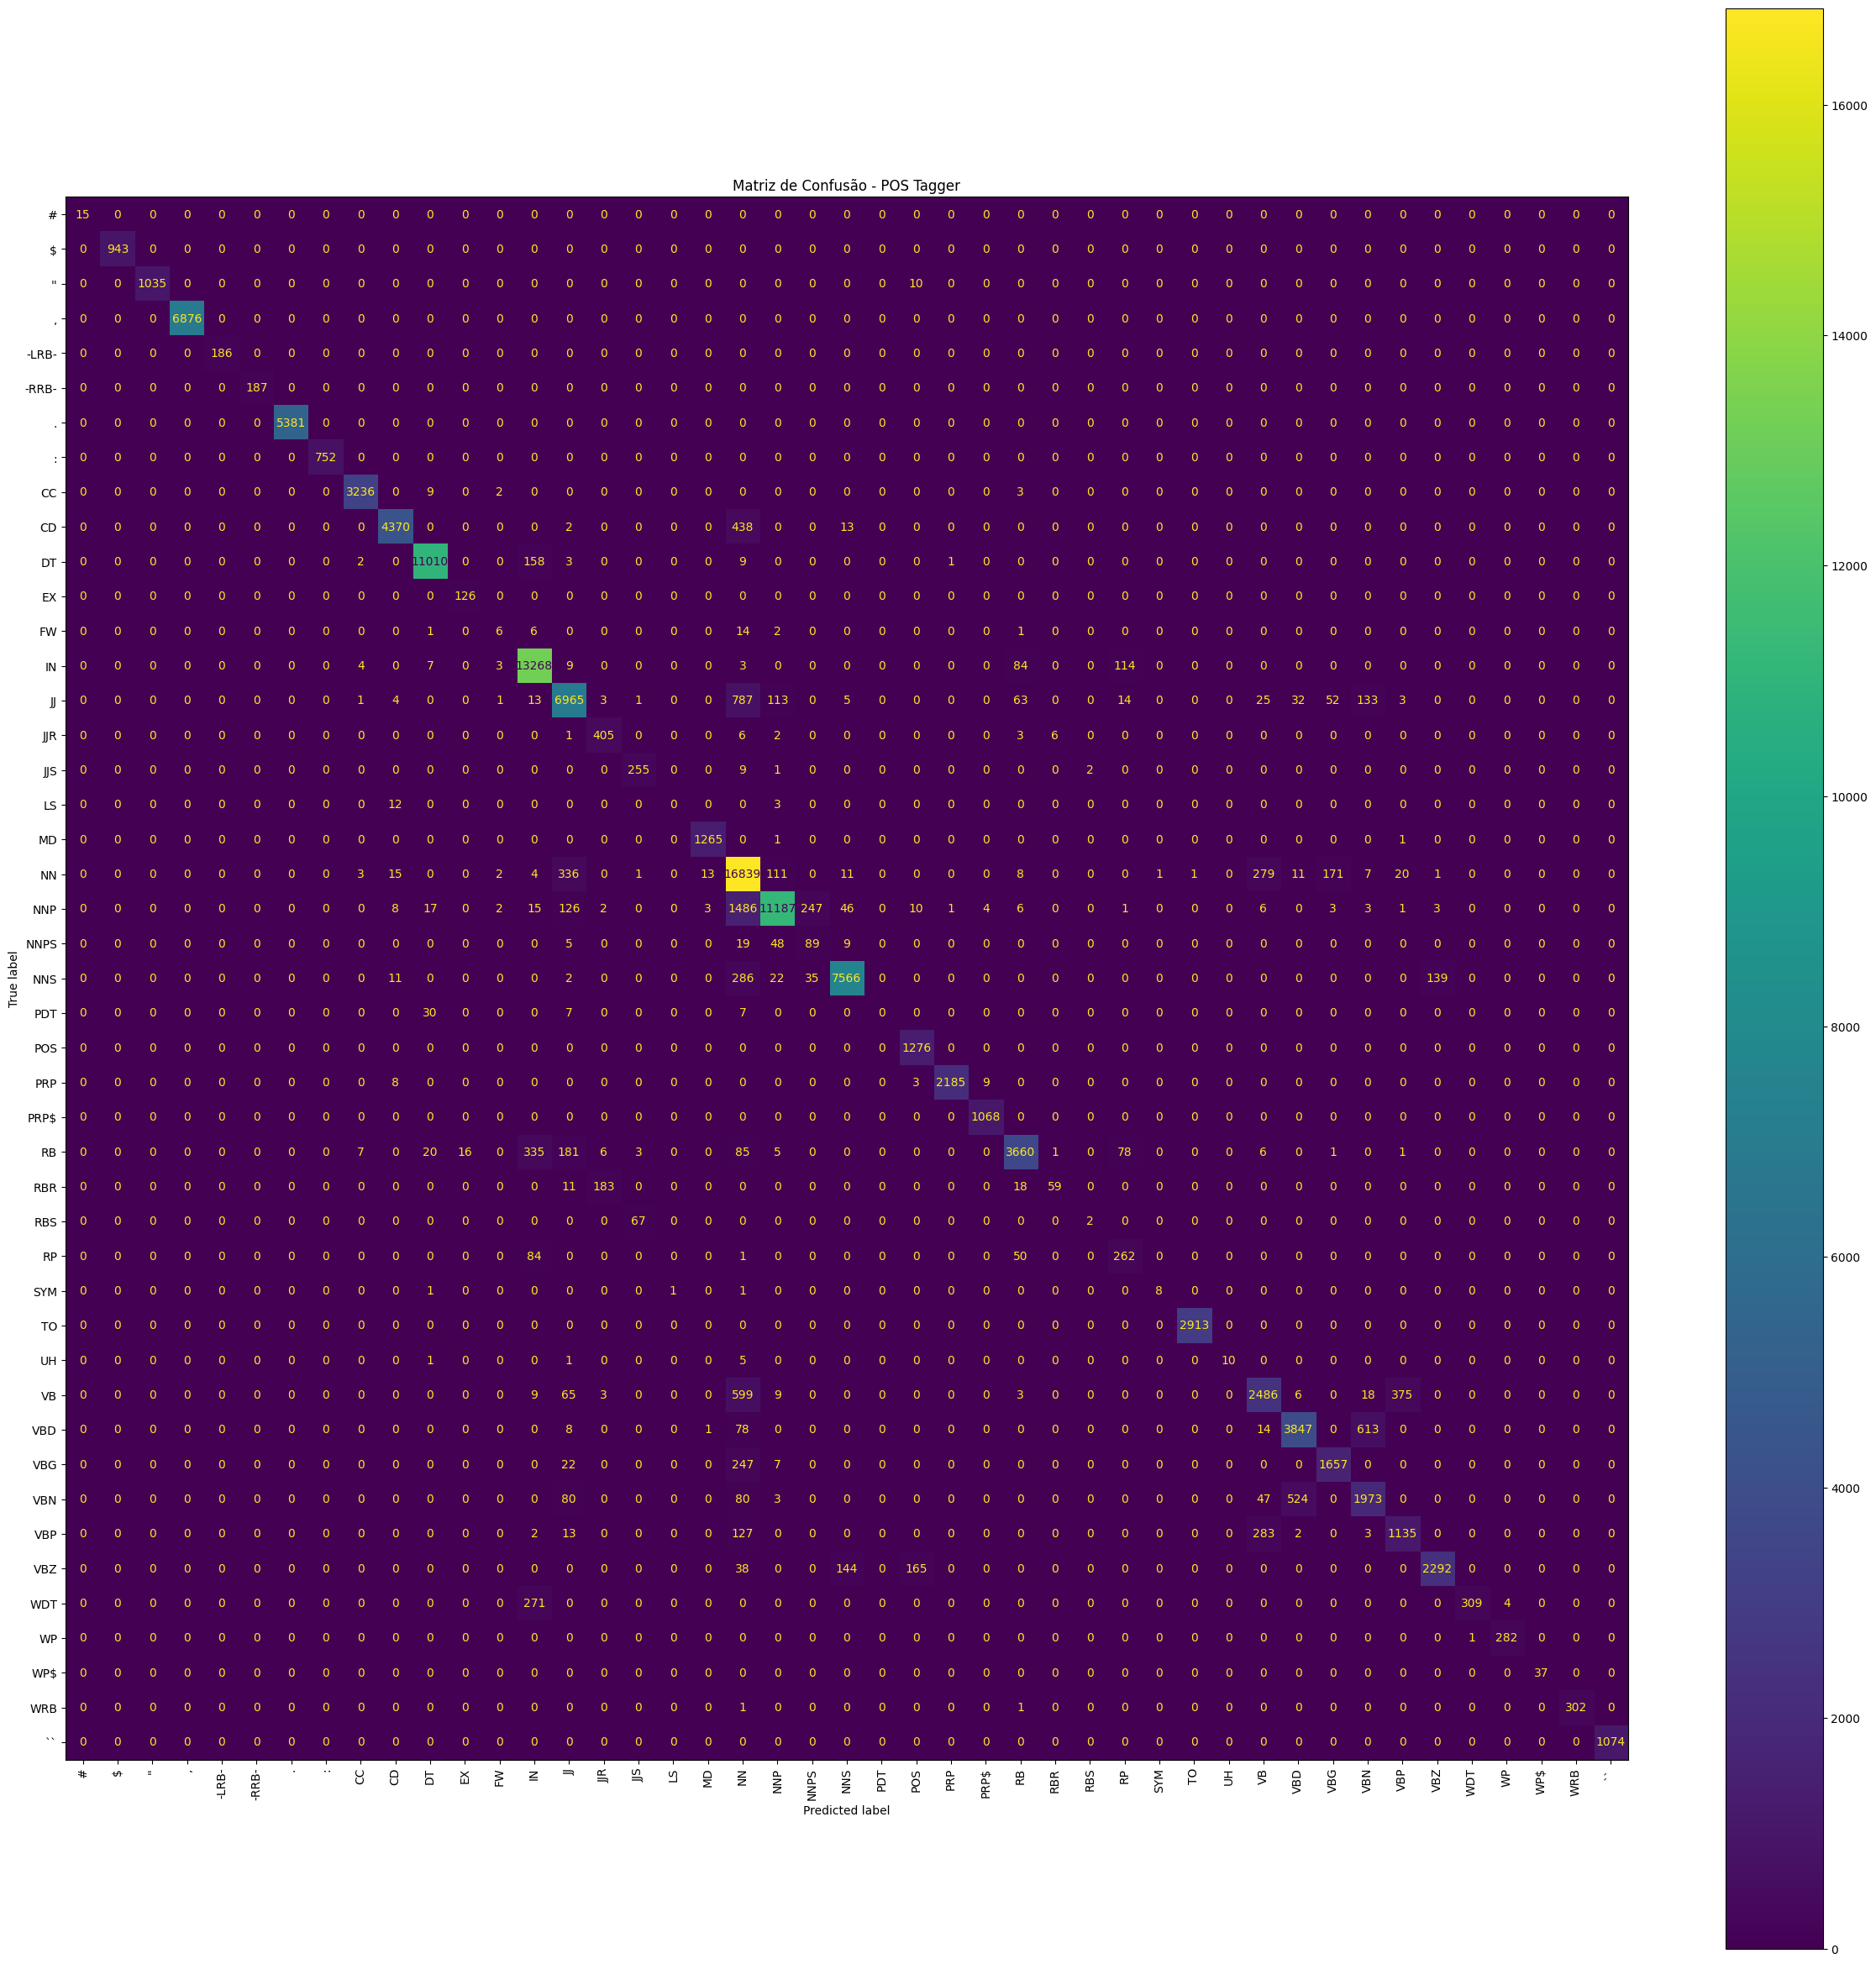

In [71]:
modelo_unigrama = treinar_baseline_unigrama(df_treino)
y_pred = prever_baseline(df_teste, modelo_unigrama, default_tag="NN")
y_true = df_teste["tag"].tolist()

print("Tags previstas:", y_pred)
print("Tags reais:    ", y_true)
print("Acurácia:", avaliar_acuracia(y_true, y_pred))

mostrar_matriz_confusao(y_true, y_pred)